<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# U.S. airport network graph

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from gensim.models import Word2Vec

import networkx as nx

from geopy.geocoders import Nominatim

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Run this before any other code cell
# This downloads the csv data files into the same directory where you have saved this notebook

import urllib.request
from pathlib import Path
import os
path = Path()

# Dictionary of file names and download links
files = {'Aug2019_flights.csv':'https://storage.googleapis.com/aipi_datasets/Aug2019_flights.csv',
        'Airport_codes.csv': 'https://storage.googleapis.com/aipi_datasets/Airport_codes.csv',
        'Airline_codes.csv': 'https://storage.googleapis.com/aipi_datasets/Airline_codes.csv'}

# Download each file
for key,value in files.items():
    filename = path/key
    url = value
    # If the file does not already exist in the directory, download it
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url,filename)

In [ ]:
def load_data(data_filename, mapper_filename):
    flight_data = pd.read_csv(data_filename)
    airport_map = pd.read_csv(mapper_filename)
    return flight_data, airport_map
    
flight_data, airport_map = load_data("Aug2019_flights.csv","Airport_codes.csv")

In [ ]:
def add_origin_and_dest(flight_data, mapper_file):
    # Add origin airports
    flight_data_mapped = pd.merge(flight_data,mapper_file,how='left',left_on='ORIGIN_AIRPORT_ID',right_on='Code')
    flight_data_mapped.rename({'Description':'ORIGIN_AIRPORT'},axis=1,inplace=True)
    flight_data_mapped['ORIGIN_CITY'] = flight_data_mapped['ORIGIN_AIRPORT'].apply(lambda x: x.split(': ')[0])
    flight_data_mapped['ORIGIN_AIRPORT'] = flight_data_mapped['ORIGIN_AIRPORT'].apply(lambda x: x.split(': ')[-1])
    
    # Add destination airports
    flight_data_mapped = pd.merge(flight_data_mapped,mapper_file,how='left',left_on='DEST_AIRPORT_ID',right_on='Code')
    flight_data_mapped.rename({'Description':'DEST_AIRPORT'},axis=1,inplace=True)
    flight_data_mapped['DEST_CITY'] = flight_data_mapped['DEST_AIRPORT'].apply(lambda x: x.split(': ')[0])
    flight_data_mapped['DEST_AIRPORT'] = flight_data_mapped['DEST_AIRPORT'].apply(lambda x: x.split(': ')[-1])
    
    flight_data_mapped = flight_data_mapped.loc[:,['FL_DATE','OP_UNIQUE_CARRIER','OP_CARRIER_FL_NUM',
                                                  'ORIGIN_AIRPORT','DEST_AIRPORT','ORIGIN_CITY','DEST_CITY']]
    
    return flight_data_mapped
                                  
flights_forgraph = add_origin_and_dest(flight_data,airport_map)
flights_forgraph.head()

,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT,DEST_AIRPORT,ORIGIN_CITY,DEST_CITY
0,8/12/19,9E,5001,Hartsfield-Jackson Atlanta International,Baton Rouge Metropolitan/Ryan Field,"Atlanta, GA","Baton Rouge, LA"
1,8/19/19,9E,5001,Hartsfield-Jackson Atlanta International,Baton Rouge Metropolitan/Ryan Field,"Atlanta, GA","Baton Rouge, LA"
2,8/26/19,9E,5001,Hartsfield-Jackson Atlanta International,Baton Rouge Metropolitan/Ryan Field,"Atlanta, GA","Baton Rouge, LA"
3,8/5/19,9E,5001,Baton Rouge Metropolitan/Ryan Field,Hartsfield-Jackson Atlanta International,"Baton Rouge, LA","Atlanta, GA"
4,8/12/19,9E,5001,Baton Rouge Metropolitan/Ryan Field,Hartsfield-Jackson Atlanta International,"Baton Rouge, LA","Atlanta, GA"


In [ ]:
# Get the count of flights between every pair of airports as the edge weights
edges = pd.DataFrame({'NUM_FLIGHTS':flights_forgraph.groupby(['ORIGIN_AIRPORT','DEST_AIRPORT']).size()}).reset_index()
edges.head()

,ORIGIN_AIRPORT,DEST_AIRPORT,NUM_FLIGHTS
0,Aberdeen Regional,Minneapolis-St Paul International,62
1,Abilene Regional,Dallas/Fort Worth International,211
2,Abraham Lincoln Capital,Chicago O'Hare International,88
3,Abraham Lincoln Capital,Dallas/Fort Worth International,61
4,Abraham Lincoln Capital,Punta Gorda Airport,3


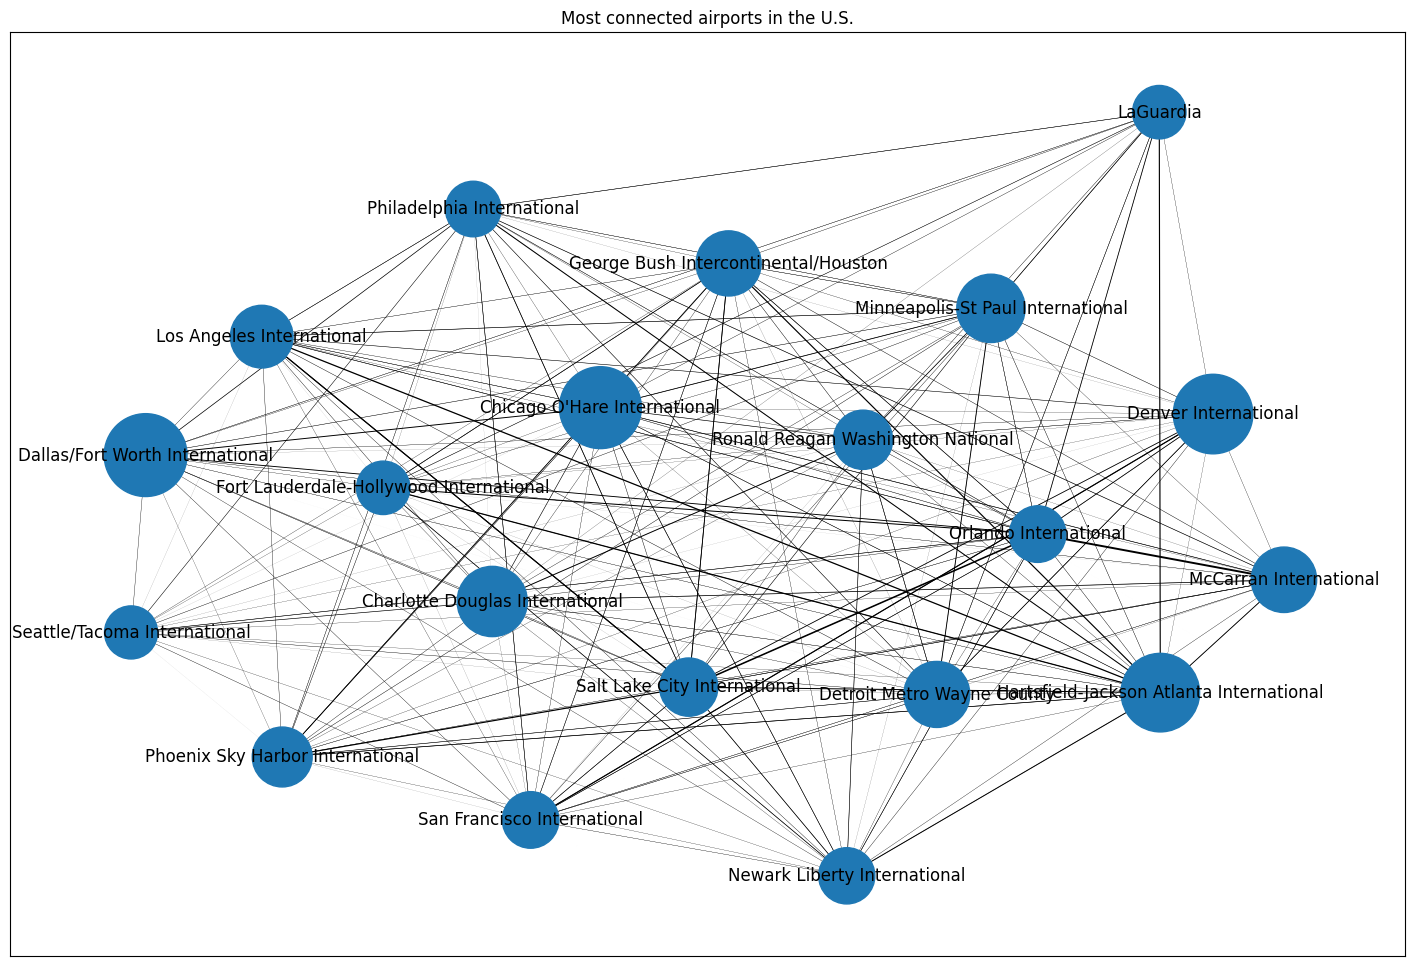

In [ ]:
# Create the graph using number of flights between airports to define the edges
G = nx.from_pandas_edgelist(edges, source='ORIGIN_AIRPORT', target='DEST_AIRPORT',edge_attr='NUM_FLIGHTS',create_using=nx.DiGraph)

# For plotting get a subgraph of the airports with the most departures
top_airports = set([airport for airport in edges['ORIGIN_AIRPORT'] if G.out_degree(airport)>70])
G_sub = G.subgraph(nodes=top_airports)

plt.figure(figsize=(18, 12))
layout = nx.spring_layout(G_sub,iterations=50)
nx.draw_networkx_nodes(G_sub,layout,nodelist=top_airports,node_size=[20*G.in_degree(airport) for airport in top_airports])

# Draw edges with width indicating count of flights between airports
weights = 3*edges['NUM_FLIGHTS']/edges['NUM_FLIGHTS'].max()
nx.draw_networkx_edges(G_sub,layout,width=weights)

node_labels = dict(zip(top_airports,top_airports))
nx.draw_networkx_labels(G_sub,layout,labels=node_labels)
plt.title('Most connected airports in the U.S.')
plt.show()

Which airports have the largest number of destinations that one can fly to?

In [ ]:
# Display out_degrees for top airports
flights = pd.DataFrame(G.out_degree(),columns=['Airport','Destinations'])
flights = flights.sort_values(by='Destinations',ascending=False)
flights[:10]

,Airport,Destinations
3,Dallas/Fort Worth International,177
5,Chicago O'Hare International,174
21,Denver International,164
12,Hartsfield-Jackson Atlanta International,160
10,Charlotte Douglas International,128
1,Minneapolis-St Paul International,121
22,Detroit Metro Wayne County,113
38,McCarran International,111
11,George Bush Intercontinental/Houston,110
37,Los Angeles International,102


How many flights between Charlotte and Raleigh-Durham?

In [ ]:
origin = 'Charlotte Douglas International'
dest = 'Raleigh-Durham International'
flights = G[origin][dest]['NUM_FLIGHTS']
print(flights)

263


## Cluster airports to identify most connected groups

In [ ]:
top_airports = set([airport for airport in edges['ORIGIN_AIRPORT'] if G.out_degree(airport)>20])
H = G.subgraph(top_airports)

In [ ]:
def get_random_walk(graph:nx.Graph, node:str, n_steps:int = 4):
    # Performs a random walk of a graph beginning at the given node
    local_path = [str(node),]
    target_node = node
    for _ in range(n_steps):
        neighbors = list(nx.all_neighbors(graph, target_node))
        target_node = random.choice(neighbors)
        local_path.append(str(target_node))
    return local_path

In [ ]:
# Get random walks beginning at every node in the graph
walk_paths = []
for node in H.nodes():
    for _ in range(100):
        walk_paths.append(get_random_walk(H, node))

In [ ]:
# Instantiate word2vec model
embedder = Word2Vec(window=4, sg=1, hs=0, negative=10, alpha=0.03, min_alpha=0.0001, seed=0)
# Build vocabulary using the random walk paths
embedder.build_vocab(walk_paths, progress_per=2)
# Create embedding for each airport and save them
embedder.train(walk_paths, total_examples=embedder.corpus_count, epochs=20, report_delay=1)
embedder.wv.save("embeddings.emb")

# Load embeddings and form feature array X with embedding for each airport
from gensim.models import KeyedVectors
emb = KeyedVectors.load('embeddings.emb')
X = np.array([emb[airport] for airport in H.nodes()])

In [ ]:
# Cluster the airports using their embeddings
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(X) # apply kmeans on Z
labels=kmeans.labels_  # get the cluster labels of the nodes.

In [ ]:
# Organize data to prepare for visualization
clusters = pd.DataFrame(data=list(H.nodes),columns=['airport'])
clusters['cluster'] = labels
clusters = clusters.merge(flights_forgraph[['ORIGIN_AIRPORT','ORIGIN_CITY']].drop_duplicates(),how='left',left_on='airport',
                         right_on='ORIGIN_AIRPORT')
clusters = clusters.drop(labels='ORIGIN_AIRPORT',axis=1)
clusters.rename(mapper={'ORIGIN_CITY':'city'},axis=1,inplace=True)
clusters['outdegree']=dict(H.out_degree()).values()

In [ ]:
# Get latitude and longitude for each city for mapping
geolocator = Nominatim(user_agent='airport_geoencoder',timeout=5)
clusters['x'] = clusters['city'].apply(lambda x: geolocator.geocode(x).longitude)
clusters['y']=clusters['city'].apply(lambda x: geolocator.geocode(x).latitude)

In [ ]:
# Create visualizaiton
import plotly.express as px
fig = px.scatter_mapbox(clusters, hover_name='airport', lat="y", lon="x", color='cluster', size='outdegree', zoom=3, height=600)
fig.update_layout(mapbox_style="stamen-terrain", mapbox_zoom=3, mapbox_center_lat = 41,
    margin={"r":0,"t":0,"l":0,"b":0}, coloraxis_showscale=False)
fig.show()
# save figure
fig.write_html("airport_clusters.html")